🧠 Question Answering Graph – LangGraph Workflow

This notebook demonstrates a LangGraph-powered workflow for retrieval-augmented question answering (QA).
It orchestrates multiple reasoning and retrieval steps to produce grounded, hallucination-checked answers using a language model and Chroma vector store retriever.

⚙️ Overview

The workflow defines a graph of interconnected nodes, each representing a step in the QA pipeline:

Initialize Workflow
Prepares the graph state and initializes tracking variables such as steps and question.

Retrieve Documents
Uses the configured retriever (e.g., a Chroma vector store) to fetch the most relevant documents for the given question.

Grade Documents
Filters and ranks the retrieved documents using a relevance grader. Only documents that receive a positive grade (e.g., “Yes”, “True”) are kept for answering.

Question Answering
Generates an answer to the question using the provided LLM (in this case, ChatGroq with the Gemma2 9B model).
The LLM only uses information from the graded documents to ensure grounded responses.

Transform Query
If the retrieved documents are not relevant enough, the workflow rewrites or reformulates the question to improve retrieval results.

Answer Validation
The generated answer is checked against the supporting documents using a hallucination checker.

If hallucinations are detected, the answer is regenerated.

If the answer is validated, the workflow ends.

In [7]:
from langgraph.graph import START, END, StateGraph
from exa_py import Exa
from langchain_groq import ChatGroq
from typing_extensions import TypedDict, List, Annotated, Optional,Dict
from IPython.display import Image, display
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.output_parsers import StrOutputParser
from langchain_core.output_parsers import JsonOutputParser
from langchain_community.vectorstores.utils import filter_complex_metadata
from kokoro import KPipeline
from IPython.display import display, Audio
from langchain.prompts import PromptTemplate
import numpy as np
import torch
import os
from exa_py import Exa
import requests
from bs4 import BeautifulSoup
from readability import Document
from urllib.parse import urlparse
import html2text
import cloudscraper
from langchain_huggingface.llms import HuggingFacePipeline
from langchain_huggingface import HuggingFaceEmbeddings
from langchain.schema import Document
from uuid import uuid4
from langchain_community.vectorstores import Chroma
from pathlib import Path
from langchain_core.documents import Document as Document2
from langsmith import traceable
from langchain_community.document_loaders import NewsURLLoader
import os
from langchain.schema.retriever import BaseRetriever
from typing_extensions import TypedDict, List, Annotated
from typing import Optional
from IPython.display import Image, display
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain.schema.retriever import BaseRetriever
from langgraph.graph import START, END, StateGraph
import datetime
import uuid
from langchain_groq import ChatGroq
from typing import TypedDict, List

C:\Users\artur\anaconda3\envs\dATA_SCIENCE_RAG\lib\site-packages\IPython\core\interactiveshell.py:3577: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\artur\anaconda3\envs\dATA_SCIENCE_RAG\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
os.environ["LANGCHAIN_API_KEY"] = 'your api key'
os.environ["LANGSMITH_TRACING"]="true"
os.environ["LANGCHAIN_ENDPOINT"]= "https://eu.api.smith.langchain.com"
os.environ["LANGCHAIN_PROJECT"] = "project name"

In [9]:
model_name = "intfloat/multilingual-e5-large-instruct"
model_kwargs = {'device': 'cpu',
                  "trust_remote_code" : 'False'}
encode_kwargs = {'normalize_embeddings': True}
embeddings = HuggingFaceEmbeddings(
        model_name=model_name,
        model_kwargs=model_kwargs,
        encode_kwargs=encode_kwargs
    )




In [135]:
persist_dir = Path(__file__).resolve().parent / "chroma"
vectorstore = Chroma(persist_directory=persist_dir, embedding_function=embeddings)

retriever = vectorstore.as_retriever(search_type="similarity", search_kwargs={"k": 3, })

# Helper function to add instructions to the query
def get_detailed_instruct(task_description: str, query: str) -> str:
    """Format a query with a task description to guide the model."""
    return f'Instruct: {task_description}\nQuery: {query}'

# Custom Retriever class with instruction-augmented queries
class InstructRetriever(BaseRetriever):
    """Retriever that adds instruction to queries before retrieval."""
    
    base_retriever: BaseRetriever = Field(...)
    task_description: str = Field(...)

    def _get_relevant_documents(self, query: str) -> List[Document]:
        """Add instruction to the query before passing to the base retriever."""
        formatted_query = get_detailed_instruct(self.task_description, query)
        return self.base_retriever.invoke(formatted_query)

task_description = "Retrieve most relevant documents to the query"

# Instruction-based retriever
instruct_retriever = InstructRetriever(
    base_retriever=retriever,
    task_description=task_description
)

instruct_retriever = InstructRetriever(base_retriever=retriever, task_description=task_description)

In [136]:
instruct_retriever.invoke("Humanoid")

[Document(metadata={'authors': "['Michael Calore', 'Will Knight', 'Kylie Robison']", 'language': 'en', 'link': 'https://www.wired.com/story/uncanny-valley-podcast-move-aside-chatbots-ai-humanoids-are-here/', 'summary': 'OpenAI is ramping up its robotics efforts by hiring researchers to develop AI systems for humanoid robots, which are becoming less clumsy and more capable. The WIRED “Uncanny Valley” podcast episode discusses this shift and the broader trend of humanoid robots entering everyday life.', 'title': 'Move Aside, Chatbots: AI Humanoids Are Here', 'topics': '- OpenAI  \n- Humanoid robots  \n- AI industry  \n- Artificial General Intelligence (AGI)  \n- Podcast “Uncanny Valley”  \n- Will Knight  \n- Michael Calore  \n- Kylie Robison  \n- Russell Brandom  \n- Bluesky  \n- Spotify  \n- iPhone/iPad Podcasts  \n- Overcast  \n- Pocket Casts  \n- “The Iron Giant” (movie)  \n- Lauren Goode  \n- AI systems for humanoid robots  \n- Robotics work  \n- Humanoid robot factory worker  \n- 20

In [27]:
def initialize_workflow(state):
    """
    Initialize the question and steps for the graph state.
    
    Args:
        state (dict): The current graph state.
        
    Returns:
        dict: Updated state with steps and question initialized.
    """
    # Get or initialize question and steps
    question = state.get("question", "")
    steps = state.get("steps", [])
    
    # Add initialization step
    steps.append("Graph Initialization")
    
    return {
        "question": question,
        "steps": steps,
    }

In [28]:
def create_hallucination_checker(llm):
    """
    Function to create a hallucination checker object using a passed LLM model.
    
    Args:
        llm: The language model to be used for checking hallucinations in the student's answer.
        
    Returns:
        Callable: A pipeline function that checks if the student's answer contains hallucinations.
    """
    

    # Define the prompt template
    prompt = PromptTemplate(
        template="""
        You are professional fact checker,  you need to check the answer: {answer} is generated using related documents {documents}, or was there made any factual mistakes, hallucinations.
        If there are mistakes , return 'yes', if no mistakes, return 'no'
        return answer as yes or no and no preamble or explanation.
        """,
        input_variables=["article", "answer"],
    )
    
    # Combine the prompt with the structured LLM hallucination checker
    hallucination_grader = prompt | llm |  StrOutputParser()

    # Return the hallucination checker object
    return hallucination_grader

In [123]:
def grade_documents(state,llm, retrieval_grader):
    question = state.get("question","")
    documents = state["documents"]
    steps = state["steps"]
    steps.append("grade_document_retrieval")
    
    filtered_docs = []
    web_results_list = []
    search = "No"
    retrieval_grader = retrieval_grader(llm)
    
    for d in documents:
        # Call the grading function
        score = retrieval_grader.invoke({"question": question, "document": d.page_content})
        print(f"Grader output for document: {score}")  # Detailed debugging output
        
        
        if score.lower() in ["yes", "true", "1"]:
            filtered_docs.append(d)
            
    # ✅ Fixed f-string syntax
    print(f"Filtered documents count: {len(filtered_docs)} from total document amount {len(documents)}")
    
    return {
        "selected_documents": filtered_docs,
        "question": question,
        "steps": steps,
    }

In [124]:
def grade_answer_v_documents(state,llm,create_hallucination_checker ):
    """
    Determines whether the generation is grounded in the document and answers the question.
    """
    print("---CHECK HALLUCINATIONS---")
    answer = state.get("answer","")
    documents = state['selected_documents']
    steps = state["steps"]
    
    
    steps.append("Check for hallucinations")
    hallucination_grader = create_hallucination_checker(llm)
    # Grading hallucinations
    score = hallucination_grader.invoke(
        {"answer": answer, "documents": documents}
    )
    

    # Check hallucination
    if score == "yes":
        print("---Found hallucinations---")
        return "Hallucinations"
        
    if score == "no":
        print("---no hallucinations---")
        return "No hallucinations"
    

In [125]:
def create_question_rewriter(llm):
    """
    Function to create a question rewriter object using a passed LLM model.
    
    Args:
        llm: The language model to be used for rewriting questions.
        
    Returns:
        Callable: A pipeline function that rewrites questions for optimized vector store retrieval.
    """
    
    # Define the prompt template for question rewriting
    re_write_prompt = PromptTemplate(
        template="""You are a question re-writer that converts an input question to a better version that is optimized for vector store retrieval.\n
        Your task is to enhance the question by clarifying the intent, removing any ambiguity, and including specific details to retrieve the most relevant information.\n
        No preamble or explanation, only the enhanced question.
        Here is the initial question: \n\n {question}.
        """,
        input_variables=["question"],
    )
    
    # Combine the prompt with the LLM and output parser
    question_rewriter = re_write_prompt | llm | StrOutputParser()

    # Return the question rewriter object
    return question_rewriter

In [126]:
def transform_query(state,llm, create_question_rewriter):
    """
    Transform the query to produce a better question.
    Args:
        state (dict): The current graph state
    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    print("---TRANSFORM QUERY---")
    question = state["question"]
    
    steps = state["steps"]
    steps.append("question_transformation")

    # Re-write question
    question_rewriter =  create_question_rewriter(llm)
    updated_question = question_rewriter.invoke({"question": question})
    print(f" Transformed question:  {updated_question}")
    return { "question": updated_question}

In [127]:
def retrieve(state , retriever):
    """
    Retrieve documents
    Args:
        state (dict): The current graph state
        retriever: The retriever object
    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    steps = state["steps"]
    question = state["question"]

    
   
    documents = retriever.invoke(question)
    
    steps.append("retrieve_documents")
    return {"documents": documents, "question": question, "steps": steps}

In [128]:
def retrieval_grader(llm):
    """
    Function to create a grader object using a passed LLM model.
    
    Args:
        llm: The language model to be used for grading.
        
    Returns:
        Callable: A pipeline function that grades relevance based on the LLM.
    """
    
    

    # Define the prompt template
    prompt = PromptTemplate(
        template="""You are a professional in understanding documents context.
        You have to identify is the retrieved document: {document} related or could be helpfull to user given question:  {question} .
        If document is related to the question , return 'yes', if no , return 'no'. 
        return answer as yes or no and no preamble or explanation.
        
        """,
        input_variables=['document', 'question'],
    )
    
    # Combine the prompt with the structured LLM grader
    retrieval_grader = prompt | llm | StrOutputParser()

    # Return the grader object
    return retrieval_grader  

In [139]:
def create_question_answerer(llm):
    """
    Creates a question-answering chain using the provided language model.
    Args:
        llm: The language model to use for generating answers.
    Returns:
        An LLMChain configured with the question-answering prompt and the provided model.
    """
    # Define the prompt template
    prompt = PromptTemplate(
        template="""You are an assistant for question-answering tasks. 
        You have to answer to the question: {question} only using these documents {documents}
        Do not repeat yourself!
        Be informative and concise.
        Use only given documents!
        """,
        input_variables=["question", "documents"],
    )

    
    rag_chain = prompt | llm | StrOutputParser()

    
    return rag_chain

In [140]:
def question_answering(state,llm,create_question_answerer):
    """
    Generate answer
    """
    question = state.get("question","")
    documents = state["documents"]
    question_answerer =  create_question_answerer(llm)
    answer = question_answerer.invoke({"documents": documents, "question": question})
    steps = state["steps"]
    steps.append("generate_answer")
    
        
    return {
        "documents": documents,
        "question": question,
        "answer": answer,
        "steps": steps,
    }

In [141]:
def related_documents_count(state):
    selected_documents = state.get("selected_documents")
    if len(selected_documents) > 0 :
        return  "Are related documents"
    else:
        return  "No related documents"

In [142]:
def question_answering_graph(retriever):
    """
    Builds the scrape/search workflow graph.

    Args:
        retriever: The retriever used to fetch documents.
    """

    from typing import TypedDict, List

    class GraphState(TypedDict):
        """
        Represents the state of our graph.
        Attributes:
            question: question
            answer: LLM-generated answer
            documents: list of retrieved documents
            steps: list of workflow steps executed
            generation_count: number of LLM generations
            search_type: type of search strategy
            k: number of top documents retrieved
            selected_documents: selected documents for answering
        """
        question: str
        answer: str
        documents: List[str]
        steps: List[str]
        generation_count: int
        search_type: str
        k: int
        selected_documents: str

    llm = ChatGroq(
        model="openai/gpt-oss-20b",  # Specify the Gemma2 9B model
        temperature=0.0,
        max_tokens=4000,
        max_retries=3,
        
    )

    # Graph
    workflow = StateGraph(GraphState)

    # --- Nodes ---
    workflow.add_node("initialize_workflow", lambda state: initialize_workflow(state))
    workflow.add_node("retrieve_documents", lambda state: retrieve(state, retriever))
    workflow.add_node( "question_answering",lambda state: question_answering(state,llm,create_question_answerer))
    workflow.add_node("grade_documents", lambda state: grade_documents(state ,llm, retrieval_grader))
    workflow.add_node("transform_query", lambda state: transform_query(state,llm, create_question_rewriter))

    # --- Graph structure ---
    workflow.set_entry_point("initialize_workflow")

    workflow.add_edge("initialize_workflow", "retrieve_documents")
    workflow.add_edge("retrieve_documents", "grade_documents")

    workflow.add_conditional_edges(
        "grade_documents",
        lambda state: related_documents_count(state),
        {
            "Are related documents": "question_answering",
            "No related documents": "transform_query",
        },
    )

    workflow.add_edge("transform_query", "retrieve_documents")

    workflow.add_conditional_edges(
        "question_answering",
        lambda state: grade_answer_v_documents(state, llm, create_hallucination_checker),
        {
            "Hallucinations": "question_answering",
            "No hallucinations": END,
        },
    )

    # Compile and return
    custom_graph = workflow.compile()
    return custom_graph

In [143]:
question_answering_graph=  question_answering_graph(instruct_retriever)

In [144]:
result = question_answering_graph.invoke({
    "question": "Who is ramping up its robotics efforts",  # Add if needed
    
})

print(result)

Grader output for document: yes
Grader output for document: no
Grader output for document: no
Filtered documents count: 1 from total document amount 3
---CHECK HALLUCINATIONS---
---no hallucinations---
{'question': 'Who is ramping up its robotics efforts', 'answer': 'OpenAI is the company ramping up its robotics efforts.', 'documents': [Document(metadata={'authors': "['Michael Calore', 'Will Knight', 'Kylie Robison']", 'language': 'en', 'link': 'https://www.wired.com/story/uncanny-valley-podcast-move-aside-chatbots-ai-humanoids-are-here/', 'summary': 'OpenAI is ramping up its robotics efforts by hiring researchers to develop AI systems for humanoid robots, which are becoming less clumsy and more capable. The WIRED “Uncanny Valley” podcast episode discusses this shift and the broader trend of humanoid robots entering everyday life.', 'title': 'Move Aside, Chatbots: AI Humanoids Are Here', 'topics': '- OpenAI  \n- Humanoid robots  \n- AI industry  \n- Artificial General Intelligence (AGI

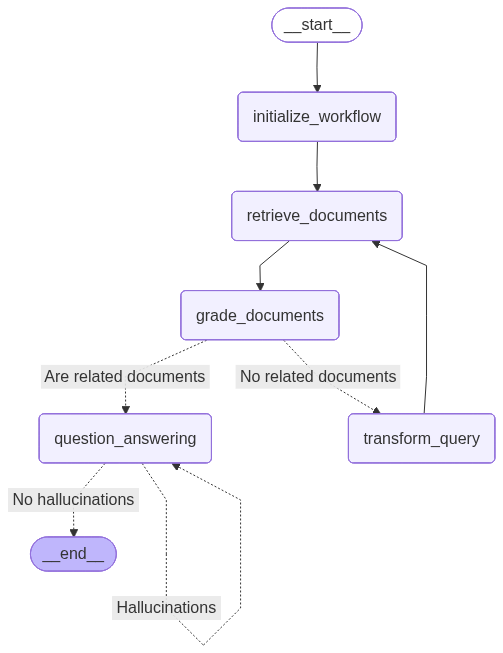

In [121]:
diagram = question_answering_graph.get_graph(xray=True).draw_mermaid_png()

# Save to file (optional)
with open("graph.png", "wb") as f:
    f.write(diagram)

display(Image(diagram))